In [1]:
from sklearn.metrics import mean_absolute_error as MSE
from cmcrameri import cm
from tqdm import tqdm
import seaborn as sns
from common import *
from models import *

2021-12-15 12:35:26.864855: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-15 12:35:26.864895: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv("../data/input_data/MAIN_DATASET.csv")

price = df['NO2_price'].values.reshape(-1,1)
aload = df['NO2_load_forecasted'].values.reshape(-1,1)
fload = df['NO2_load_actual'].values.reshape(-1,1)
fgen = df['NO2_generation_forecast'].values.reshape(-1,1)
agen = df['NO2_generation_actual'].values.reshape(-1,1)


price_days = seperate_column_to_days(price)
aload_days = seperate_column_to_days(aload)
fload_days = seperate_column_to_days(fload)
fgen_days = seperate_column_to_days(fgen)
agen_days = seperate_column_to_days(agen)

In [3]:
lookbehind = 7
input_width = lookbehind*24
horizon = 24
no_hours = input_width + horizon
hour_in_days = int(no_hours / 24)

price_dataset = []
aload_dataset = []
fload_dataset = []
fgen_dataset = []
agen_dataset = []

for i in range(len(price_days) - hour_in_days+1):
    price_dataset.append(np.concatenate((price_days[i:i+hour_in_days])))
    aload_dataset.append(np.concatenate((aload_days[i:i+hour_in_days])))
    fload_dataset.append(np.concatenate((fload_days[i:i+hour_in_days])))
    fgen_dataset.append(np.concatenate((fgen_days[i:i+hour_in_days])))
    agen_dataset.append(np.concatenate((agen_days[i:i+hour_in_days])))

price_dataset = np.array(price_dataset)
aload_dataset = np.array(aload_dataset)
fload_dataset = np.array(fload_dataset)
fgen_dataset = np.array(fgen_dataset)
agen_dataset = np.array(agen_dataset)

scaler = MinMaxScaler()
price_dataset = scaler.fit_transform(price_dataset[:,:,0])
price_dataset = price_dataset[..., np.newaxis].astype(np.float32)

aload_dataset = scaler.fit_transform(aload_dataset[:,:,0])
aload_dataset = aload_dataset[..., np.newaxis].astype(np.float32)

fload_dataset = scaler.fit_transform(fload_dataset[:,:,0])
fload_dataset = fload_dataset[..., np.newaxis].astype(np.float32)

fgen_dataset = scaler.fit_transform(fgen_dataset[:,:,0])
fgen_dataset = fgen_dataset[..., np.newaxis].astype(np.float32)

agen_dataset = scaler.fit_transform(agen_dataset[:,:,0])
agen_dataset = agen_dataset[..., np.newaxis].astype(np.float32)

dataset_actual = np.concatenate((price_dataset, aload_dataset, agen_dataset), axis=2)
dataset_forecast = np.concatenate((price_dataset, fload_dataset, fgen_dataset), axis=2)

n,m,k = dataset_actual.shape

# Splitting the data, actual case

In [4]:
train = int(0.7*n)
valid = int(0.9*n)
X_train = dataset_actual[:train, :input_width]
X_valid = dataset_actual[train:valid, :input_width]
X_test = dataset_actual[valid:, :input_width]

Y = np.empty((n, input_width, horizon))
for step_ahead in range(1, horizon + 1):
    Y[:,:, step_ahead - 1] = dataset_actual[:,step_ahead:step_ahead + input_width, 0]

Y_train = Y[:train]
Y_valid = Y[train:valid]
Y_test = Y[valid:]

# Grid search, first small then large architecture

In [5]:
epochs = 10
no_neurons = np.array([16,32,64,128])
mse_list_small_actual = np.zeros((3, len(no_neurons)))
best_mse_small_actual = np.inf*np.ones(3)

In [6]:
for n, neurons in enumerate(no_neurons):
    print(f"Iteration {n}")
    rnn = keras.models.Sequential([
        keras.layers.SimpleRNN(neurons, return_sequences=True, input_shape=[None, k]),
        keras.layers.Dense(horizon)
    ])

    lstm = keras.models.Sequential([
        keras.layers.LSTM(neurons, return_sequences=True, input_shape=[None, k]),
        keras.layers.Dense(horizon)
    ])

    gru = keras.models.Sequential([
        keras.layers.GRU(neurons, return_sequences=True, input_shape=[None, k]),
        keras.layers.Dense(horizon)
    ])

    rnn.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
    lstm.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
    gru.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

    rnn.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
    lstm.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
    gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)

    Y_pred_rnn = rnn.predict(X_test)
    Y_pred_lstm = lstm.predict(X_test)
    Y_pred_gru = gru.predict(X_test)

    mse_rnn = MSE(Y_test[:,-1], Y_pred_rnn[:,-1])
    mse_lstm = MSE(Y_test[:,-1], Y_pred_lstm[:,-1])
    mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])

    if mse_rnn < best_mse_small_actual[0]:
        print(f"Found new best SimpleRNN mse {mse_rnn} with {neurons} neurons")
        best_mse_small_actual[0] = mse_rnn
        fname = f"../data/models/multivariate_actual_small_rnn.h5"
        keras.models.save_model(rnn, fname)

    if mse_lstm < best_mse_small_actual[1]:
        print(f"Found new best LSTM mse {mse_lstm} with {neurons} neurons")
        best_mse_small_actual[1] = mse_lstm
        fname = f"../data/models/multivariate_actual_small_lstm.h5"
        keras.models.save_model(lstm, fname)
        

    if mse_gru < best_mse_small_actual[2]:
        print(f"Found new best GRU mse {mse_gru} with {neurons} neurons")
        best_mse_small_actual[2] = mse_gru
        fname = f"../data/models/multivariate_actual_small_gru.h5"
        keras.models.save_model(gru, fname)

    mse_list_small_actual[0,n] = mse_rnn
    mse_list_small_actual[1,n] = mse_lstm
    mse_list_small_actual[2,n] = mse_gru


Iteration 0


2021-12-15 12:35:33.457450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-15 12:35:33.457572: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-15 12:35:33.457628: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-15 12:35:33.457677: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-15 12:35:33.457739: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Found new best SimpleRNN mse 0.21858688033167542 with 16 neurons
Found new best LSTM mse 0.12863526312197254 with 16 neurons
Found new best GRU mse 0.13016115666875783 with 16 neurons
Iteration 1
Found new best SimpleRNN mse 0.1607561036914397 with 32 neurons
Found new best LSTM mse 0.10289859897770803 with 32 neurons
Found new best GRU mse 0.10491374492157635 with 32 neurons
Iteration 2
Found new best SimpleRNN mse 0.11602109963416946 with 64 neurons
Found new best LSTM mse 0.09761184416158725 with 64 neurons
Found new best GRU mse 0.0918256214616587 with 64 neurons
Iteration 3
Found new best SimpleRNN mse 0.09613334706056438 with 128 neurons
Found new best LSTM mse 0.09627021393933305 with 128 neurons
Found new best GRU mse 0.08378563250707109 with 128 neurons


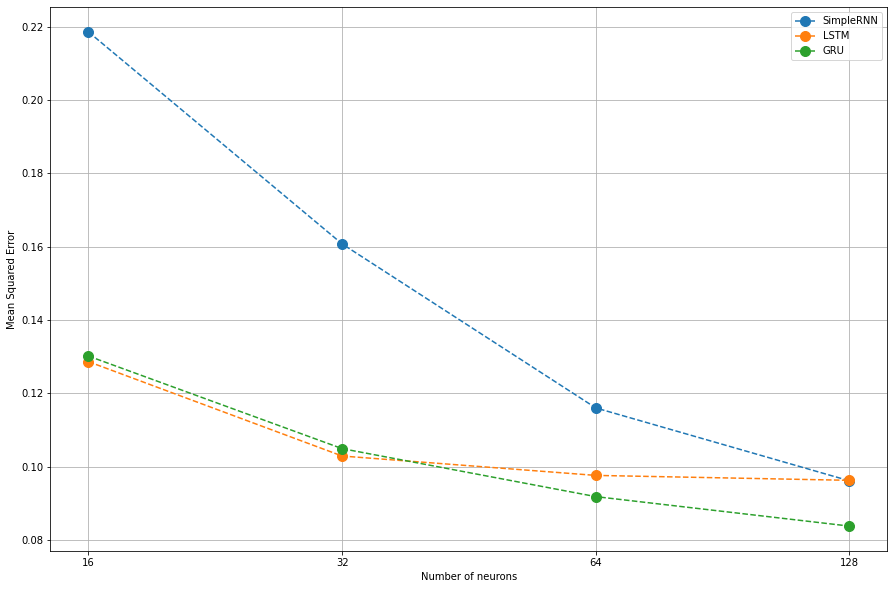

In [7]:
plt.figure(figsize=(15,10))
plt.plot(mse_list_small_actual[0], '.--', markersize=20, label="SimpleRNN")
plt.plot(mse_list_small_actual[1], '.--', markersize=20, label="LSTM")
plt.plot(mse_list_small_actual[2], '.--', markersize=20, label="GRU")
plt.xticks(ticks = np.arange(4), labels=no_neurons)
plt.xlabel(f"Number of neurons")
plt.ylabel(f"Mean Squared Error")
plt.grid()
plt.legend()
plt.savefig(f"../figures/multivariate_actual_small_architecture_grid_search.pdf")

In [8]:
mse_list_actual = np.zeros((3, len(no_neurons), len(no_neurons)))
best_mse_actual = np.inf*np.ones(3)

In [9]:
for n, neurons_first in enumerate(no_neurons):
    for m, neurons_second in enumerate(no_neurons):
        print(f"Iteration {n}{m}")
        rnn = keras.models.Sequential([
            keras.layers.SimpleRNN(neurons_first, return_sequences=True, input_shape=[None, k]),
            keras.layers.SimpleRNN(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        lstm = keras.models.Sequential([
            keras.layers.LSTM(neurons_first, return_sequences=True, input_shape=[None, k]),
            keras.layers.LSTM(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        gru = keras.models.Sequential([
            keras.layers.GRU(neurons_first, return_sequences=True, input_shape=[None, k]),
            keras.layers.GRU(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        rnn.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
        lstm.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
        gru.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

        rnn.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
        lstm.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
        gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)

        Y_pred_rnn = rnn.predict(X_test)
        Y_pred_lstm = lstm.predict(X_test)
        Y_pred_gru = gru.predict(X_test)

        mse_rnn = MSE(Y_test[:,-1], Y_pred_rnn[:,-1])
        mse_lstm = MSE(Y_test[:,-1], Y_pred_lstm[:,-1])
        mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])

        if mse_rnn < best_mse_actual[0]:
            print(f"Found new best SimpleRNN mse {mse_rnn} with {neurons_first} and {neurons_second} neurons")
            best_mse_actual[0] = mse_rnn
            fname = f"../data/models/multivariate_actual_large_rnn.h5"
            keras.models.save_model(rnn, fname)

        if mse_lstm < best_mse_actual[1]:
            print(f"Found new best LSTM mse {mse_lstm} with {neurons_first} and {neurons_second} neurons")
            best_mse_actual[1] = mse_lstm
            fname = f"../data/models/multivariate_actual_large_lstm.h5"
            keras.models.save_model(lstm, fname)

        if mse_gru < best_mse_actual[2]:
            print(f"Found new best GRU mse {mse_gru} with {neurons_first} and {neurons_second} neurons")
            best_mse_actual[2] = mse_gru
            fname = f"../data/models/multivariate_actual_large_gru.h5"
            keras.models.save_model(gru, fname)

        mse_list_actual[0,n,m] = mse_rnn
        mse_list_actual[1,n,m] = mse_lstm
        mse_list_actual[2,n,m] = mse_gru

Iteration 00
Found new best SimpleRNN mse 0.17645221386461882 with 16 and 16 neurons
Found new best LSTM mse 0.1296498706711194 with 16 and 16 neurons
Found new best GRU mse 0.12409281784967867 with 16 and 16 neurons
Iteration 01
Found new best SimpleRNN mse 0.1606828862608762 with 16 and 32 neurons
Found new best LSTM mse 0.11191854825441583 with 16 and 32 neurons
Found new best GRU mse 0.0995785555651366 with 16 and 32 neurons
Iteration 02
Found new best SimpleRNN mse 0.12872660893776916 with 16 and 64 neurons
Found new best LSTM mse 0.09788005857630648 with 16 and 64 neurons
Found new best GRU mse 0.08488146163216055 with 16 and 64 neurons
Iteration 03
Found new best SimpleRNN mse 0.09857729337556886 with 16 and 128 neurons
Found new best LSTM mse 0.09065110722343424 with 16 and 128 neurons
Found new best GRU mse 0.08364136453775393 with 16 and 128 neurons
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Found new best SimpleRNN mse 0.09418663463278816 with 32 and 128 neurons
Ite

In [10]:
print(mse_list_actual)
print(best_mse_actual)

[[[0.17645221 0.16068289 0.12872661 0.09857729]
  [0.17271575 0.15378808 0.14028224 0.09418663]
  [0.16820069 0.1379098  0.12795185 0.12155625]
  [0.13796742 0.11529249 0.10852715 0.08440283]]

 [[0.12964987 0.11191855 0.09788006 0.09065111]
  [0.12462541 0.09717819 0.09795022 0.09784298]
  [0.12906381 0.09649697 0.09230362 0.09319971]
  [0.1201539  0.0948354  0.08686831 0.07813634]]

 [[0.12409282 0.09957856 0.08488146 0.08364136]
  [0.12384272 0.09955048 0.09398722 0.08560869]
  [0.11059567 0.09638885 0.09252466 0.08189484]
  [0.11439156 0.08802918 0.08248176 0.07766347]]]
[0.08440283 0.07813634 0.07766347]


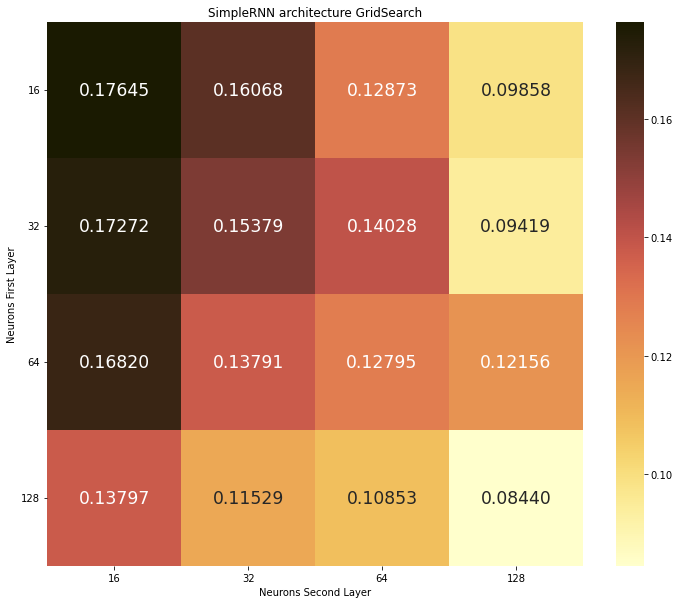

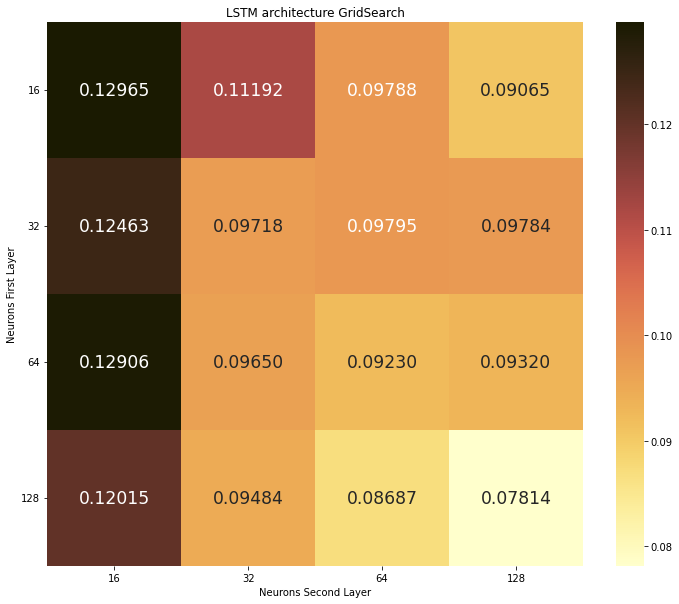

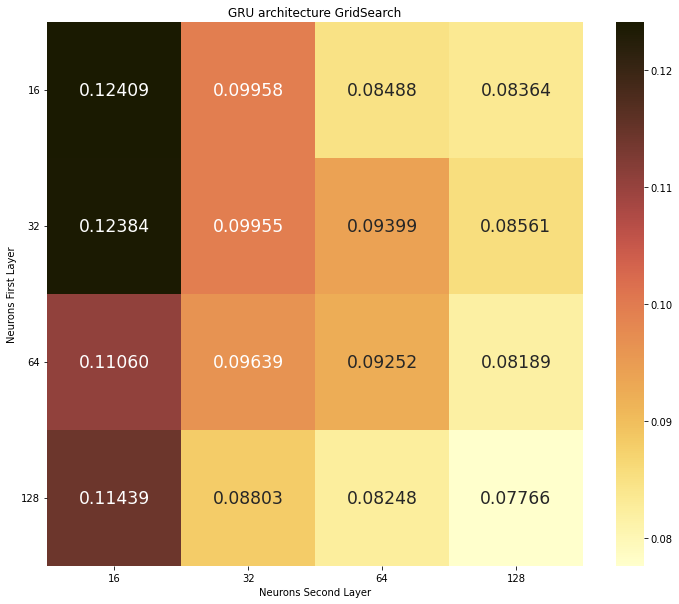

In [48]:
plt.figure(figsize=(12,10))
gridsearch = sns.heatmap(mse_list_actual[0],annot=True, annot_kws={'fontsize':'xx-large'}, fmt=".5f", xticklabels= no_neurons, yticklabels= no_neurons, cmap=cm.lajolla)
gridsearch.set_yticklabels(gridsearch.get_yticklabels(),rotation = 0)

plt.title("SimpleRNN architecture GridSearch")
plt.xlabel("Neurons Second Layer")
plt.ylabel("Neurons First Layer")
plt.savefig(f"../figures/Large_actual_gridsearch_rnn.pdf")

plt.figure(figsize=(12,10))
gridsearch = sns.heatmap(mse_list_actual[1],annot=True, annot_kws={'fontsize':'xx-large'}, fmt=".5f", xticklabels= no_neurons, yticklabels= no_neurons, cmap=cm.lajolla)
gridsearch.set_yticklabels(gridsearch.get_yticklabels(),rotation = 0)

plt.title("LSTM architecture GridSearch")
plt.xlabel("Neurons Second Layer")
plt.ylabel("Neurons First Layer")
plt.savefig(f"../figures/Large_actual_gridsearch_lstm.pdf")

plt.figure(figsize=(12,10))
gridsearch = sns.heatmap(mse_list_actual[2],annot=True, annot_kws={'fontsize':'xx-large'}, fmt=".5f", xticklabels= no_neurons, yticklabels= no_neurons, cmap=cm.lajolla)
gridsearch.set_yticklabels(gridsearch.get_yticklabels(),rotation = 0)

plt.title("GRU architecture GridSearch")
plt.xlabel("Neurons Second Layer")
plt.ylabel("Neurons First Layer")
plt.savefig(f"../figures/Large_actual_gridsearch_gru.pdf")

# Splitting the data, forecast case

In [33]:
n,m,k = dataset_forecast.shape

train = int(0.7*n)
valid = int(0.9*n)
X_train = dataset_forecast[:train, :input_width]
X_valid = dataset_forecast[train:valid, :input_width]
X_test = dataset_forecast[valid:, :input_width]

Y = np.empty((n, input_width, horizon))
for step_ahead in range(1, horizon + 1):
    Y[:,:, step_ahead - 1] = dataset_forecast[:,step_ahead:step_ahead + input_width, 0]

Y_train = Y[:train]
Y_valid = Y[train:valid]
Y_test = Y[valid:]

In [34]:
epochs = 10
no_neurons = np.array([16,32,64,128])
mse_list_small_forecast = np.zeros((3, len(no_neurons)))
best_mse_small_forecast = np.inf*np.ones(3)

In [35]:
for n, neurons in enumerate(no_neurons):
    print(f"Iteration {n}")
    rnn = keras.models.Sequential([
        keras.layers.SimpleRNN(neurons, return_sequences=True, input_shape=[None, k]),
        keras.layers.Dense(horizon)
    ])

    lstm = keras.models.Sequential([
        keras.layers.LSTM(neurons, return_sequences=True, input_shape=[None, k]),
        keras.layers.Dense(horizon)
    ])

    gru = keras.models.Sequential([
        keras.layers.GRU(neurons, return_sequences=True, input_shape=[None, k]),
        keras.layers.Dense(horizon)
    ])

    rnn.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
    lstm.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
    gru.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

    rnn.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
    lstm.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
    gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)

    Y_pred_rnn = rnn.predict(X_test)
    Y_pred_lstm = lstm.predict(X_test)
    Y_pred_gru = gru.predict(X_test)

    mse_rnn = MSE(Y_test[:,-1], Y_pred_rnn[:,-1])
    mse_lstm = MSE(Y_test[:,-1], Y_pred_lstm[:,-1])
    mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])

    if mse_rnn < best_mse_small_forecast[0]:
        print(f"Found new best SimpleRNN mse {mse_rnn} with {neurons} neurons")
        best_mse_small_forecast[0] = mse_rnn
        fname = f"../data/models/multivariate_forecast_small_rnn.h5"
        keras.models.save_model(rnn, fname)

    if mse_lstm < best_mse_small_forecast[1]:
        print(f"Found new best LSTM mse {mse_lstm} with {neurons} neurons")
        best_mse_small_forecast[1] = mse_lstm
        fname = f"../data/models/multivariate_forecast_small_lstm.h5"
        keras.models.save_model(lstm, fname)
        

    if mse_gru < best_mse_small_forecast[2]:
        print(f"Found new best GRU mse {mse_gru} with {neurons} neurons")
        best_mse_small_forecast[2] = mse_gru
        fname = f"../data/models/multivariate_forecast_small_gru.h5"
        keras.models.save_model(gru, fname)

    mse_list_small_forecast[0,n] = mse_rnn
    mse_list_small_forecast[1,n] = mse_lstm
    mse_list_small_forecast[2,n] = mse_gru


Iteration 0
Found new best SimpleRNN mse 0.18756588000031382 with 16 neurons
Found new best LSTM mse 0.12745353227809425 with 16 neurons
Found new best GRU mse 0.12767417538401815 with 16 neurons
Iteration 1
Found new best SimpleRNN mse 0.13204281293115333 with 32 neurons
Found new best LSTM mse 0.1248395289058672 with 32 neurons
Found new best GRU mse 0.10517069711338765 with 32 neurons
Iteration 2
Found new best SimpleRNN mse 0.10739558993921443 with 64 neurons
Found new best LSTM mse 0.09333833664420739 with 64 neurons
Found new best GRU mse 0.08712538841003314 with 64 neurons
Iteration 3
Found new best SimpleRNN mse 0.08103673556201976 with 128 neurons
Found new best LSTM mse 0.08526601851256904 with 128 neurons
Found new best GRU mse 0.08125604732860608 with 128 neurons


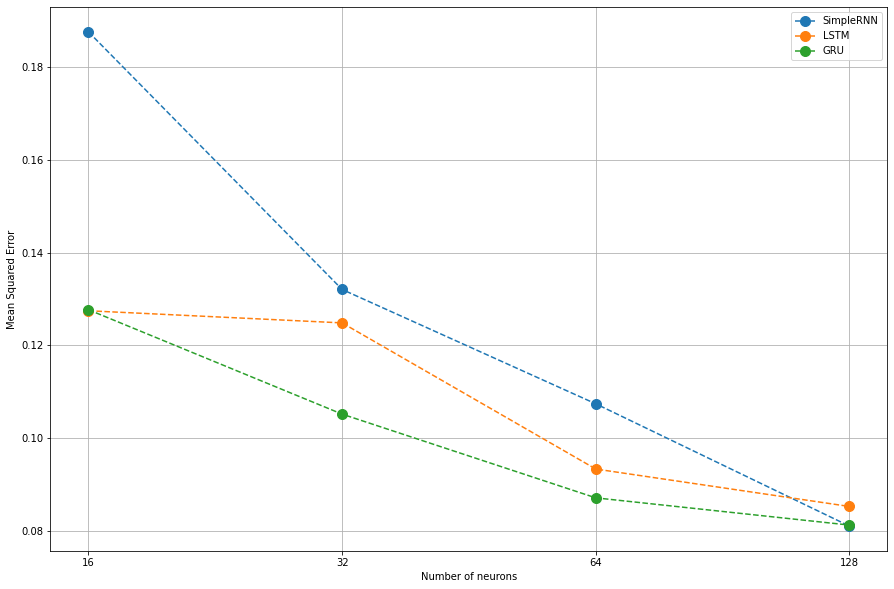

In [36]:
plt.figure(figsize=(15,10))
plt.plot(mse_list_small_forecast[0], '.--', markersize=20, label="SimpleRNN")
plt.plot(mse_list_small_forecast[1], '.--', markersize=20, label="LSTM")
plt.plot(mse_list_small_forecast[2], '.--', markersize=20, label="GRU")
plt.xticks(ticks = np.arange(4), labels=no_neurons)
plt.xlabel(f"Number of neurons")
plt.ylabel(f"Mean Squared Error")
plt.grid()
plt.legend()
plt.savefig(f"../figures/multivariate_forecast_small_architecture_grid_search.pdf")

In [37]:
mse_list_forecast = np.zeros((3, len(no_neurons), len(no_neurons)))
best_mse_forecast = np.inf*np.ones(3)

In [38]:
for n, neurons_first in enumerate(no_neurons):
    for m, neurons_second in enumerate(no_neurons):
        print(f"Iteration {n}{m}")
        rnn = keras.models.Sequential([
            keras.layers.SimpleRNN(neurons_first, return_sequences=True, input_shape=[None, k]),
            keras.layers.SimpleRNN(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        lstm = keras.models.Sequential([
            keras.layers.LSTM(neurons_first, return_sequences=True, input_shape=[None, k]),
            keras.layers.LSTM(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        gru = keras.models.Sequential([
            keras.layers.GRU(neurons_first, return_sequences=True, input_shape=[None, k]),
            keras.layers.GRU(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        rnn.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
        lstm.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
        gru.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

        rnn.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
        lstm.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
        gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)

        Y_pred_rnn = rnn.predict(X_test)
        Y_pred_lstm = lstm.predict(X_test)
        Y_pred_gru = gru.predict(X_test)

        mse_rnn = MSE(Y_test[:,-1], Y_pred_rnn[:,-1])
        mse_lstm = MSE(Y_test[:,-1], Y_pred_lstm[:,-1])
        mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])

        if mse_rnn < best_mse_forecast[0]:
            print(f"Found new best SimpleRNN mse {mse_rnn} with {neurons_first} and {neurons_second} neurons")
            best_mse_forecast[0] = mse_rnn
            fname = f"../data/models/multivariate_forecast_large_rnn.h5"
            keras.models.save_model(rnn, fname)

        if mse_lstm < best_mse_forecast[1]:
            print(f"Found new best LSTM mse {mse_lstm} with {neurons_first} and {neurons_second} neurons")
            best_mse_forecast[1] = mse_lstm
            fname = f"../data/models/multivariate_forecast_large_lstm.h5"
            keras.models.save_model(lstm, fname)

        if mse_gru < best_mse_forecast[2]:
            print(f"Found new best GRU mse {mse_gru} with {neurons_first} and {neurons_second} neurons")
            best_mse_forecast[2] = mse_gru
            fname = f"../data/models/multivariate_forecast_large_gru.h5"
            keras.models.save_model(gru, fname)

        mse_list_forecast[0,n,m] = mse_rnn
        mse_list_forecast[1,n,m] = mse_lstm
        mse_list_forecast[2,n,m] = mse_gru

Iteration 00
Found new best SimpleRNN mse 0.18050571024143225 with 16 and 16 neurons
Found new best LSTM mse 0.1259816731812488 with 16 and 16 neurons
Found new best GRU mse 0.10795207918509386 with 16 and 16 neurons
Iteration 01
Found new best SimpleRNN mse 0.15536880473353296 with 16 and 32 neurons
Found new best LSTM mse 0.10619625157318958 with 16 and 32 neurons
Found new best GRU mse 0.10698339978019693 with 16 and 32 neurons
Iteration 02
Found new best SimpleRNN mse 0.13228940072028708 with 16 and 64 neurons
Found new best LSTM mse 0.09229110980777899 with 16 and 64 neurons
Found new best GRU mse 0.08824249939844712 with 16 and 64 neurons
Iteration 03
Found new best SimpleRNN mse 0.09420796333306497 with 16 and 128 neurons
Found new best LSTM mse 0.09112211458135606 with 16 and 128 neurons
Found new best GRU mse 0.08680197777767724 with 16 and 128 neurons
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 20
Iteration 21
Iteration 22
Found new best GRU mse 0.0863504803

In [39]:
print(mse_list_forecast)
print(best_mse_forecast)

[[[0.18050571 0.1553688  0.1322894  0.09420796]
  [0.18613898 0.1468781  0.13151512 0.10160221]
  [0.1536935  0.13925838 0.12584863 0.09731571]
  [0.13204828 0.12165001 0.11434303 0.0856351 ]]

 [[0.12598167 0.10619625 0.09229111 0.09112211]
  [0.1133472  0.10717011 0.09530314 0.09113386]
  [0.10349339 0.10321114 0.09949456 0.09597324]
  [0.1131712  0.09715539 0.08436504 0.08230679]]

 [[0.10795208 0.1069834  0.0882425  0.08680198]
  [0.10400819 0.09588142 0.08966205 0.08698424]
  [0.0995944  0.09963257 0.08635048 0.08342789]
  [0.11042914 0.09272494 0.07719694 0.07929763]]]
[0.0856351  0.08230679 0.07719694]


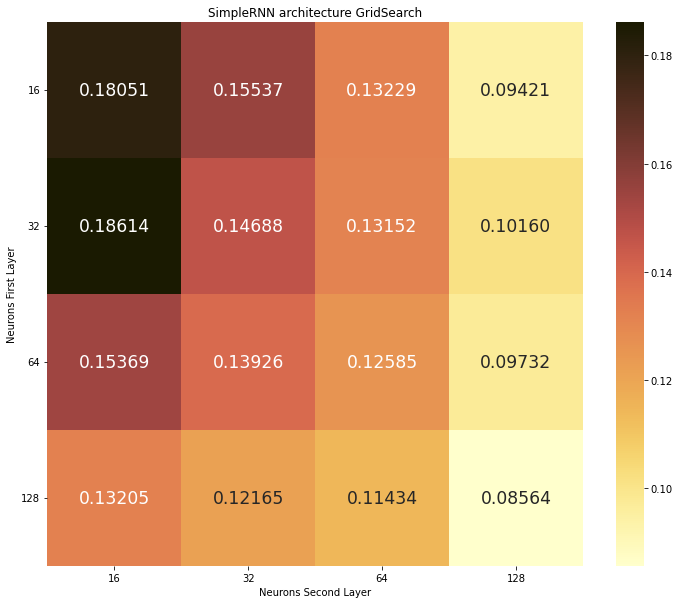

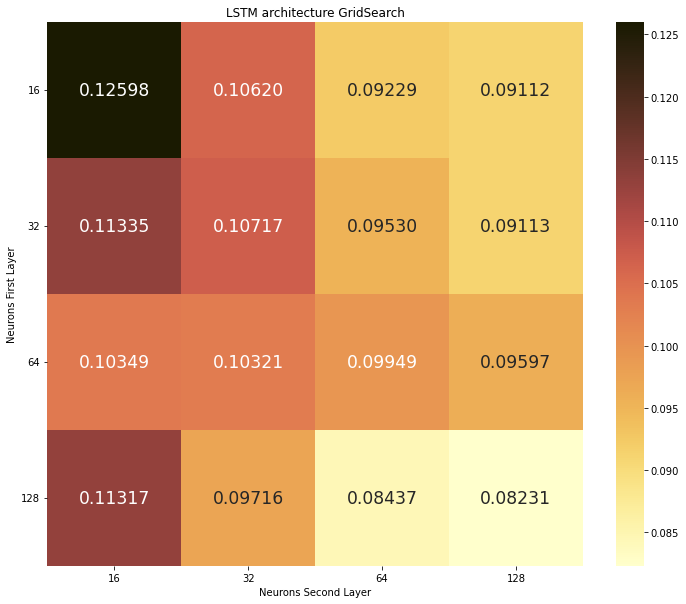

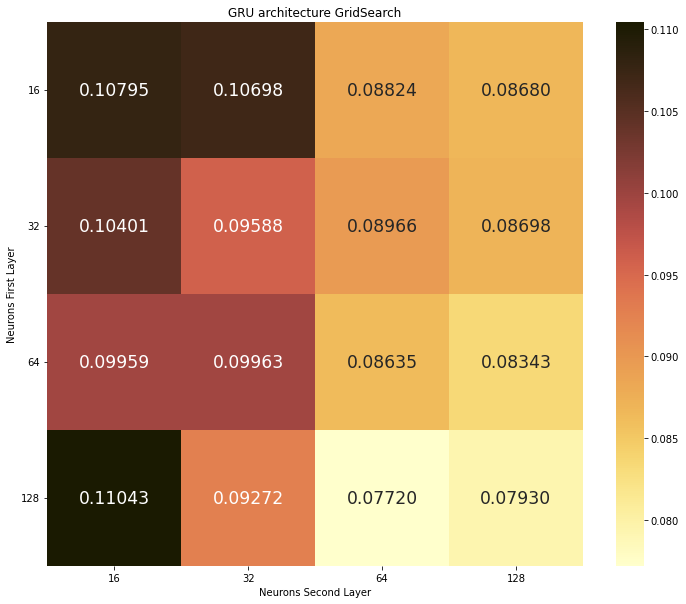

In [47]:
fig = plt.figure(figsize=(12,10))
gridsearch = sns.heatmap(mse_list_forecast[0],annot=True, annot_kws={'fontsize':'xx-large'}, fmt=".5f", xticklabels= no_neurons, yticklabels= no_neurons, cmap=cm.lajolla)
gridsearch.set_yticklabels(gridsearch.get_yticklabels(),rotation = 0)

plt.title("SimpleRNN architecture GridSearch")
plt.xlabel("Neurons Second Layer")
plt.ylabel("Neurons First Layer")
plt.savefig(f"../figures/Large_forecast_gridsearch_rnn.pdf")

fig = plt.figure(figsize=(12,10))
gridsearch = sns.heatmap(mse_list_forecast[1],annot=True, annot_kws={'fontsize':'xx-large'}, fmt=".5f", xticklabels= no_neurons, yticklabels= no_neurons, cmap=cm.lajolla)
gridsearch.set_yticklabels(gridsearch.get_yticklabels(),rotation = 0)

plt.title("LSTM architecture GridSearch")
plt.xlabel("Neurons Second Layer")
plt.ylabel("Neurons First Layer")
plt.savefig(f"../figures/Large_forecast_gridsearch_lstm.pdf")

plt.figure(figsize=(12,10))
gridsearch = sns.heatmap(mse_list_forecast[2],annot=True, annot_kws={'fontsize':'xx-large'}, fmt=".5f", xticklabels= no_neurons, yticklabels= no_neurons, cmap=cm.lajolla)
gridsearch.set_yticklabels(gridsearch.get_yticklabels(),rotation = 0)

fig = plt.title("GRU architecture GridSearch")
plt.xlabel("Neurons Second Layer")
plt.ylabel("Neurons First Layer")
plt.savefig(f"../figures/Large_forecast_gridsearch_gru.pdf")